# YZV 303E Term Project: Retinal Layer Segmentation of OCT Images

* Öykü Eren, 150200326
* Bora Boyacıoğlu, 150200310

## 1. Data Processing and Saving

This part is specific for loading the OCTA 500 data, applying transformations if necessary, and saving it into a NumPy archive file to use it later.

Import necessary libraries.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

from scipy.io import loadmat
import cv2

import openpyxl

In [ ]:
# For better visualisations
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

Import the data from Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Define the global variables.

In [ ]:
# Image extension
IMG_EXT = '.bmp'

# Define the sizes for preprocessing
IMG_SIZE = 640
CROP_SIZE = 400
RESIZE = 512

Get the data locations.

In [ ]:
data_location = 'drive/MyDrive/OCTA500/Optovue'

In [ ]:
oct_loc = data_location + '/OCT_DATA'
labels_loc = data_location + '/LAYER_DATA'

Import utils from Drive.

### Loading the Images

Define a stack loader function. This will read and combine all the slices of one sample.

In [ ]:
def preprocess(img):
    """ Preprocessing the images in the loop
    """

    # Get the image sizes
    s0, s1 = img.shape[:2]  # Height, Width

    # Crop the image
    y0 = (s0 - CROP_SIZE) // 2
    y1 = CROP_SIZE + y0
    img = img[y0:y1, :, :]

    # Add padding to the 3mm images
    if s1 < CROP_SIZE:
        w = max((CROP_SIZE - s1) // 2, 0)
        img = cv2.copyMakeBorder(img, 0, 0, w, w, cv2.BORDER_CONSTANT, value=(0, 0, 0))

    # Resize the image
    img = cv2.resize(img, (RESIZE, RESIZE))

    return img

In [ ]:
def load_3d_img(path, read_slices):
    """Load 2D image slices from a specified path, normalize the pixel values, and stack them along the last axis to form a 3D image.
    """

    slices = []
    current_slices = []

    # Read the slices
    for i in read_slices:
        sliced = None
        j = i

        """
        Some of the files are broken.
        This means, we need to try to find the next non-empty slice.
        """
        while True:
            try:
                file_path = path + '/' + str(j) + IMG_EXT
                sliced = cv2.imread(file_path)
                sliced = sliced.astype('float32') / 255.0
                current_slices.append(j)
                break
            except AttributeError:
                j -= 1

        # Preprocess the slice
        sliced = preprocess(sliced)
        slices.append(sliced)

    return slices, current_slices

Run the stack loader for each sample. Using the results, build arrays for 3mm and 6mm OCT images, as well as the layers.

In [ ]:
def label_preprocess(label, read_slices):
    """ Preprocessing the labels in the loop
    """

    # Crop the label
    y0 = (IMG_SIZE - CROP_SIZE) // 2
    y1 = CROP_SIZE + y0

    label = label - y0
    label = np.clip(label, 0, y1 - y0)

    slice_count = len(read_slices)
    width = label.shape[2]

    # Convert the label to mask
    mask = np.zeros((slice_count, 6, y1 - y0, width), dtype=np.uint8)
    for i, depth in enumerate(read_slices):
        sliced = label[:, depth, :]
        for j, layer in enumerate(sliced):
            for x, y in enumerate(layer):
                y = int(y)
                if 0 <= y < y1 - y0:
                    mask[i, j, y, x] = 1

    # Resize the mask
    mask_ = np.zeros((slice_count, 6, RESIZE, RESIZE), dtype=np.uint8)

    for i in range(6):
        for sliced in range(slice_count):
            layer = mask[sliced, i]

            # Add padding to the 3mm labels
            if width < CROP_SIZE:
                w = max((CROP_SIZE - width) // 2, 0)
                layer = cv2.copyMakeBorder(mask[sliced, i], 0, 0, w, w, cv2.BORDER_CONSTANT, value=(0, 0, 0))

            mask_[sliced, i] = (cv2.resize(layer, (RESIZE, RESIZE), interpolation=cv2.INTER_NEAREST))

    return mask_

In [ ]:
# For test purposes, only work with a couple of samples
test = True
s6, s3 = 10, 10
test_sample = ["10833_OD", "11170_OD", "2320_OS", "322_OS", "9796_OS"]

# Number of slices to work with
slice_count = 20
read_slices = [int((400 / slice_count) * (i + 1) - 1) for i in range(slice_count)]

# Define the arrays
oct = []
label_ = []

processed = 0

# Iterate over samples
for i in test_sample:
    processed += 1
    # The case for 6mm
    print(f'Processing 6mm, Sample: {i}, Slices: {slice_count}...')

    # Load the image
    path = oct_loc + '/' + str(i)
    img, read_slice = load_3d_img(path, read_slices)
    oct.append(img)

    # Add the label
    path_label = labels_loc + '/' + str(i) + '.mat'
    mat = loadmat(path_label)['Layer']
    label = label_preprocess(mat, read_slice)
    label_.append(label)

print('-- PROCESSING DONE --')
print(f'From {processed} samples and {slice_count} slices of each, a total of {processed * slice_count} slices processed.')

Processing 6mm, Sample: 10833_OD, Slices: 20...
Processing 6mm, Sample: 11170_OD, Slices: 20...
Processing 6mm, Sample: 2320_OS, Slices: 20...
Processing 6mm, Sample: 322_OS, Slices: 20...
Processing 6mm, Sample: 9796_OS, Slices: 20...
-- PROCESSING DONE --
From 5 samples and 20 slices of each, a total of 100 slices processed.


In [ ]:
oct = np.concatenate(oct, axis=0)
print(oct.shape)

label_ = np.concatenate(label_, axis=0)
print(label_.shape)


(100, 512, 512, 3)
(100, 6, 512, 512)


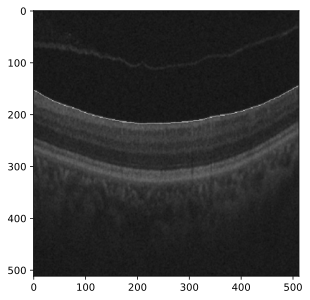

In [ ]:
sample = 2 # [0, 4]
sliced = 3  # [0, 19]
layer = 0   # [0, 5]

n = sample * 20 + sliced

plt.imshow(oct[n])
plt.imshow(label_[n][layer], cmap='gray', alpha=0.75)

# Show the plot
plt.show()

In [ ]:
save_location = '/content/drive/MyDrive/OCTA500/Project/data/'

# Check for test purposes
if test:
    save_location += 'test/'

np.savez_compressed(f'{save_location}testing_opt.npz', img=oct, mask=label_)
#np.savez_compressed(f'{save_location}test.npz', img=X_test, mask=y_test)
print("Saving Done.")

Saving Done.
